In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from pathlib import Path

In [4]:
# create engine to hawaii.sqlite
database_path = Path('../Resources/hawaii.sqlite')
engine = create_engine(f"sqlite:///{database_path}")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# engine.execute("SELECT date FROM measurement ORDER BY date DESC LIMIT 1;")
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

Text(0, 0.5, 'Inches')

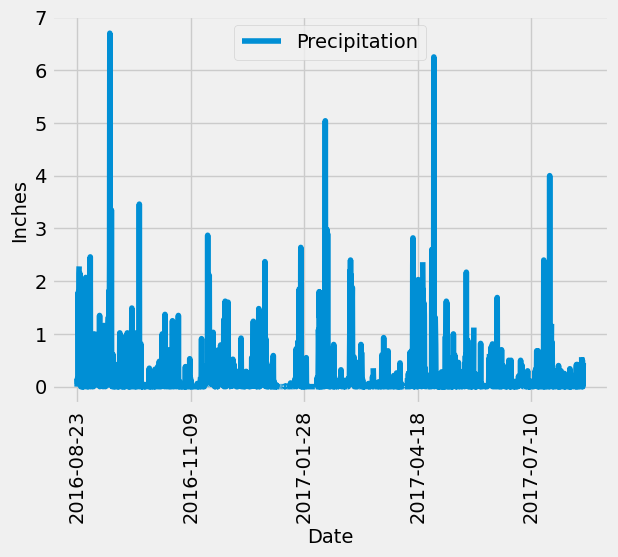

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date_to = dt.date(2017, 8, 23)
# Calculate the date one year from the last date in data set.
date_from = date_to - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
# engine.execute("SELECT date, prcp FROM measurement WHERE date BETWEEN '2016-08-23' AND '2017-08-23' ORDER BY date;")
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_from).\
filter(Measurement.date <= date_to).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_rows = [{'Date': result[0], 'Precipitation': result[1]} for result in results]
df = pd.DataFrame(prcp_rows).set_index('Date')

# Sort the dataframe by date
df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
# engine.execute("SELECT COUNT(DISTINCT(station)) FROM measurement;")
session.query(func.count(func.distinct(Measurement.station))).all()

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# engine.execute("SELECT station, COUNT(*) FROM measurement GROUP BY station ORDER BY COUNT(*) DESC;")
active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_station[0][0]

# engine.execute("SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE station = 'USC00519281';")
stations_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
stations_temp

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

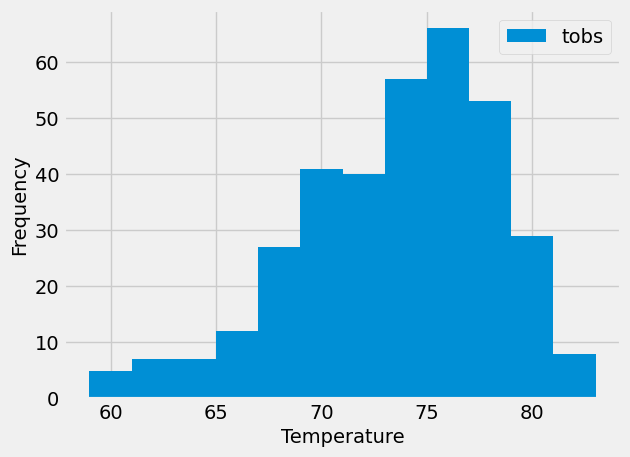

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# engine.execute("SELECT tobs FROM measurement WHERE station = 'USC00519281' AND date >= '2016-08-23' AND date <= '2017-08-23';")
station_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= date_from).\
filter(Measurement.date <= date_to)

temp_rows = [{'tobs': temp[0]} for temp in station_temp]
df_temp = pd.DataFrame(temp_rows)
df_temp.plot(kind='hist', bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')

# Close Session

In [16]:
# Close Session
session.close()